**Library Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import nltk
from nltk.corpus import words
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

Mount Google Drive and Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load data
df = pd.read_csv('/content/drive/MyDrive/password_strength_dataset/data1.csv')

Mounted at /content/drive


In [ ]:
df.head()

,password,strength
0,kzde5577,1.0
1,kino3434,1.0
2,visi7k1yr,1.0
3,megzy123,1.0
4,lamborghin1,1.0


Feature Engineering Functions
Functions to extract features from passwords:

In [ ]:
def extract_count_digits(s): return sum(char.isdigit() for char in str(s))  # Count digits
def extract_count_lowercase(s): return sum(char.islower() for char in str(s))  # Count lowercase letters
def extract_count_uppercase(s): return sum(char.isupper() for char in str(s))  # Count uppercase letters
def extract_count_special(s): return sum(not char.isalnum() for char in str(s))  # Count special characters
def extract_length(s): return len(str(s))  # Password length


Entropy Calculation

In [ ]:
def calculate_entropy(s):
    s = str(s)
    prob = [s.count(c)/len(s) for c in set(s)]  # Probabilities of each unique character
    return -sum(p * math.log(p, 2) for p in prob)  # Shannon entropy formula


Sequential Characters (e.g., "123", "abc")

In [ ]:
def count_sequential_chars(s):
    s = str(s).lower()
    sequences = re.findall(r'(012|123|234|...|qwerty)', s)  # Look for known sequences
    return len(sequences)


Dictionary Word Count in Password

In [ ]:
nltk.download('words')  # Download English dictionary
english_words = set(words.words())

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-letters
    return text.split()

def count_dictionary_words(text, dictionary):
    return len([word for word in preprocess_text(str(text)) if word in dictionary])


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


 **Create New Features in Dataset**


Apply the feature engineering functions:

In [ ]:

df['length'] = df['password'].apply(extract_length)
df['digit_count'] = df['password'].apply(extract_count_digits)
df['lowercase_count'] = df['password'].apply(extract_count_lowercase)
df['uppercase_count'] = df['password'].apply(extract_count_uppercase)
df['special_count'] = df['password'].apply(extract_count_special)
df['entropy'] = df['password'].apply(calculate_entropy)
df['sequential_chars'] = df['password'].apply(count_sequential_chars)
df['dictionary_word_count'] = df['password'].apply(lambda x: count_dictionary_words(x, english_words))

Data Cleaning

In [ ]:
df1 = df.drop(columns=['password']).drop_duplicates().dropna(subset=['strength'])  # Remove unwanted rows/columns

📊 Correlation Heatmap (Exploratory Data Analysis)


<Axes: >

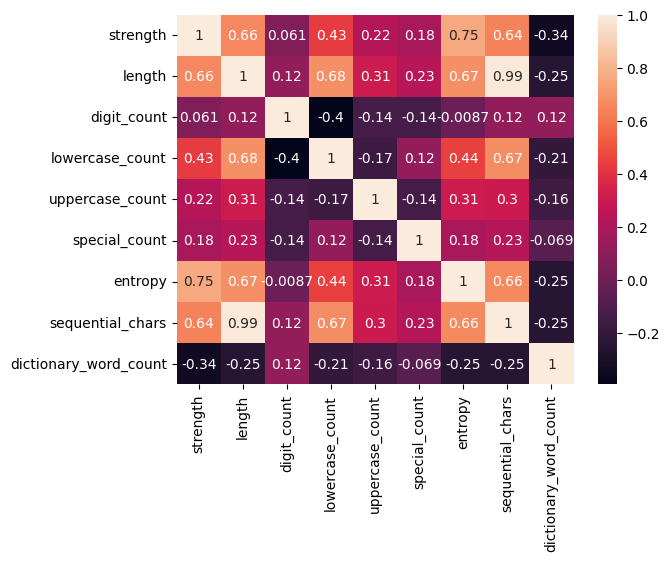

In [ ]:
sns.heatmap(df1.corr(), annot=True)  # Visualizes how features are correlated with each other


In [ ]:
# Clean the dataset
df1 = df.drop(columns=['password']).drop_duplicates().dropna(subset=['strength'])

In [ ]:
df1.head()

,strength,length,digit_count,lowercase_count,uppercase_count,special_count,entropy,sequential_chars,dictionary_word_count
0,1.0,8,4,4,0,0,2.500000,2,0
1,1.0,8,4,4,0,0,2.500000,2,1
2,1.0,9,2,7,0,0,2.947703,3,0
3,1.0,8,3,5,0,0,3.000000,2,0
4,1.0,11,1,10,0,0,3.459432,3,0


In [ ]:
# Save the cleaned DataFrame to CSV
output_path = '/content/drive/MyDrive/password_strength_dataset/cleaned_password_strength.csv'
df1.to_csv(output_path, index=False)

print(f"Dataset saved to: {output_path}")

Split Data for Model Training

In [ ]:
X = df1.drop(columns=['strength'])  # Features
y = df1['strength']                 # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional but useful)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)


Model Building and Ensemble

In [ ]:
svc = make_pipeline(StandardScaler(), LinearSVC(random_state=42))  # SVM pipeline with scaling
rf = RandomForestClassifier(n_estimators=100, random_state=42)     # Random Forest model

ensemble = VotingClassifier(estimators=[('svc', svc), ('rf', rf)], voting='hard')  # Combine both models


Training and Evaluation

In [ ]:
ensemble.fit(X_train_scaled_df, y_train)           # Train the ensemble model
y_pred = ensemble.predict(X_test_scaled_df)        # Predict on test set

# Evaluation
print(confusion_matrix(y_test, y_pred))            # Show confusion matrix

[[ 179    6    0]
 [  13 1753    0]
 [   0    0 3507]]


In [ ]:
print(accuracy_score(y_test, y_pred))              # Accuracy score


0.9965188713814584


In [ ]:
print(classification_report(y_test, y_pred, digits=4))  # Precision, recall, f1-score

              precision    recall  f1-score   support

         0.0     0.9323    0.9676    0.9496       185
         1.0     0.9966    0.9926    0.9946      1766
         2.0     1.0000    1.0000    1.0000      3507

    accuracy                         0.9965      5458
   macro avg     0.9763    0.9867    0.9814      5458
weighted avg     0.9966    0.9965    0.9965      5458



In [ ]:

error_rate = 1 - accuracy_score(y_test, y_pred)
print(f"Error Rate: {error_rate:.4f}")


Error Rate: 0.0035
